# Breakout 🎮🕹️


## Packages

In [1]:
#!pip install gym[atari]

In [2]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt 
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

/usr/local/insa/anaconda/envs/GPU/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os
root = os.getcwd() #To get PATH directory
save = root + "/save"
#os.chdir(r'C:\Users\Quentin\Documents\5 GMM Projet\save')  # to change the current directory
os.chdir(save)

## Class Agent

In [6]:
class DQN_Breakout_Agent:
    def __init__(self, action_size):
        samples_frame_size = 4
        self.state_size = (samples_frame_size, 84, 74)
        self.action_size = action_size
        
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.96
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.current_state = deque(maxlen=samples_frame_size) # processing batch of frames

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    # enregistre ce qu'il a fait et stock dans son deque(=liste avec limite)
    def remember(self, state, action, reward, next_frame, done):
        # state -> deque 4x84x74
        # next_frame -> array 84x74
        
        # between the current_state and the next one, 3 frames are the same and don't
        # need to stored twice -> let's just store the new frame on the next state
        self.memory.append((state, action, reward, next_frame, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # Hazard
        else :
            # Approximation de la ligne de la Q table avec le réseau de neurone
            batch_state = deque_to_batch(state)
            act_values = self.model.predict(batch_state) # Keras need a 4x84x74x1 batch
            return np.argmax(act_values[0])  # returns action ()
    
    def learn(self, state, action, reward, next_frame, done):
        batch_state = deque_to_batch(state)
        next_state = state
        next_state.append(next_frame)
        batch_next_state = deque_to_batch(next_state)
        
        target = reward
        if not done:
            target = (reward + self.gamma *
                      np.amax(self.model.predict(batch_next_state)[0]))
        target_f = self.model.predict(batch_state)
        target_f[0][action] = target
        self.model.fit(batch_state, target_f, epochs=1, verbose=0)
        
    # Rejoue et apprend batch_size événement au hazard dans son deque
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_frame, done in minibatch:
            self.learn(state, action, reward, next_frame, done)
            
    def refresh(self):
        if self.epsilon > self.epsilon_min :
            self.epsilon *= self.epsilon_decay
            
    # On initialise en écrasant tout     
    def init_current_state(self, frm):
        for i in range(self.samples_frame_size):
            self.current_state.append(frm)
        return self.current_state
    
    # update the 4 current batch frames
    def update_current_state(self, next_frame):
        self.current_state.append(next_frame)
        return self.current_state
    
    # Return an 4x84x74x1 batch
    def get_frame_stack(self):
        return np.copy(np.array([self.frame_stack]))

    # Loading or saving neural network weights
    def load(self, name):
        self.model.load_weights(name)
    def save(self, name):
        self.model.save_weights(name)
        
    # from frame_stack to normalized batch 4x84x74x1
    def deque_to_batch(deque):
        array_frame_stack = np.array(deque)              # convert deque into 4x84x74 array
        array_frame_stack = array_frame_stack / 255      # normalize from [0,255] to [0,1]
        return np.expand_dims(array_frame_stack, axis=3) # add one dimension: 4x84x74x1 array

## New fonctions

In [7]:
def preprocessing(img):
    """
    Gray-scale, reduce edges and down-sampling img to a 84×74 image
    """
    return np.mean(img, axis=2).astype(np.uint8)[30:-12,6:-6][::2,::2]

def reward_clipping(reward):
    return np.sign(reward)

## Main

In [12]:
env = gym.make('Breakout-v0')
a = env.reset()

In [22]:
print(a.shape)
a = a/255
print(a[50:55,:5,0])

(210, 160, 3)
[[0.55686275 0.55686275 0.55686275 0.55686275 0.55686275]
 [0.55686275 0.55686275 0.55686275 0.55686275 0.55686275]
 [0.55686275 0.55686275 0.55686275 0.55686275 0.55686275]
 [0.55686275 0.55686275 0.55686275 0.55686275 0.55686275]
 [0.55686275 0.55686275 0.55686275 0.55686275 0.55686275]]


In [8]:
env = gym.make('Breakout-v0')
print("State size : %s\nAction size : %s"%(env.observation_space.shape,env.action_space.n))

agent = DQN_Breakout_Agent(action_size = env.action_space.n)

EPISODES = 10
TIME_LIMIT = 1e8

DISPLAY = True

State size : (210, 160, 3)
Action size : 4


TypeError: Error converting shape to a TensorShape: int() argument must be a string, a bytes-like object or a number, not 'tuple'.

In [47]:
for e in range(EPISODES):
    color_frame = env.reset()
    frame = preprocessing(color_frame)
    state = init_current_state(frame) # Pour avoit un deque initiale 4x84x74
    
    score = 0
    for time in range(TIME_LIMIT):
        #env.render()        
        action = agent.act(state)
        color_next_frame, reward, done, info = env.step(action) # take a action
        
        # clips rewards to 1 or -1
        reward = reward_clipping(reward)
        if reward > 0 : score += 1
            
        # Dès qu'on perd une vie sur les 5, on considère qu'on a perdu
        #if info['ale.lives'] < 5 :
        #    done = True

        # image preprocessing
        next_frame = preprocessing(color_next_frame) 
        
        # remember
        agent.remember(state, action, reward, next_frame, done)
        
        # update the current state 4x84x74
        state = agent.update_current_state(next_frame)
        
        
        if len(agent.memory) > batch_size: # On se souvient si on a joué au moins batch_size fois.
            agent.replay(batch_size)       # On n'apprend que sur ses souvenirs, pas sur le coup immédiat
        
        if done and DISPLAY:
            print("episode: {}, score: {:.2}, e: {:.2}"
                  .format(e, score, agent.epsilon))
            break

    agent.refresh() # update epsillon 
    #if e % 10 == 8:
        #agent.save("lunarlander-dqn.h5")
env.close()

## Tests

In [48]:
obs = env.reset()
obs = np.array(obs)
#env.render()
I = preprocessing(obs)

(84, 74)
(210, 160, 3)


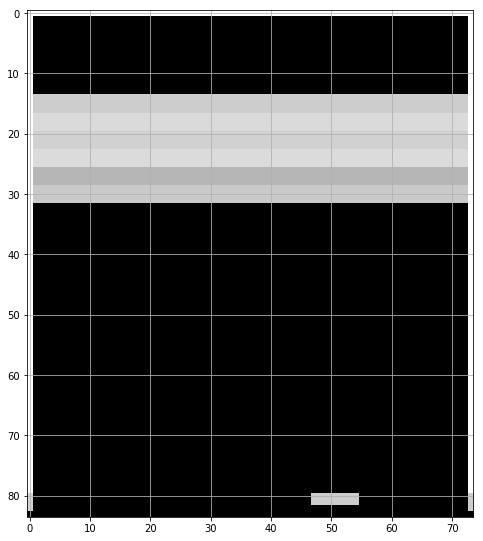

In [49]:
I = obs[::2,::2,:]
I = obs
print(preprocessing(obs).shape)
print(obs.shape)

size = 8
plt.figure(figsize=(size,size*21/16))
#plt.imshow(obs,"gray")
#plt.imshow(obs,"gray")
plt.imshow(preprocessing(obs),"gray")
plt.grid(True)
plt.show()

(2, 4, 84, 74)
<class 'numpy.ndarray'>


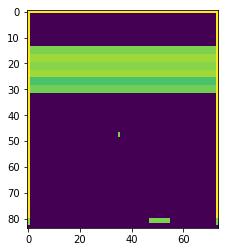

In [50]:
frame = preprocessing(frame)
II = []
I_list = []
I_list.append(frame)
I_list.append(frame)
I_list.append(frame)
I_list.append(frame)
II.append(I_list)
II.append(I_list)

II = np.array(II)

print(II.shape)
print(type(II))
plt.imshow(II[0][0])

In [36]:
obs, reward, done, info = env.step(0)
print(info)
print(info['ale.lives'])


{'ale.lives': 2}
2


In [4]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    f = plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    plt.close(f)
    plt.gcf()

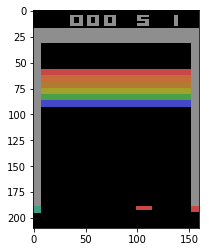

NEW GAME
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.liv

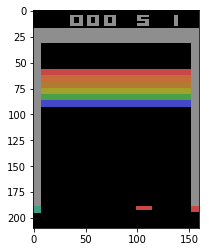

NEW GAME
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.liv

In [6]:
import time as t
env = gym.make('Breakout-v0')

for _ in range(2):
    obs = env.reset()
    obs = np.array(obs)
    plt.imshow(obs)
    plt.show()
    I_list = []
    print("NEW GAME")
    for time in range(100):
        #plot_environment(env)
        #t.sleep(0.5)
        frame, reward, done, info = env.step(env.action_space.sample()) # take a random action
        if info['ale.lives'] < 5 :
            done = True
        print(reward, done, info)
        I_list.append(frame)
        if done :
            print("BREAK***********************************")
            break
        """
        print("time: %s"%time)
        plt.figure(figsize=(4,4*21/16))
        plt.imshow(preprocessing(frame),"gray")
        plt.grid(False)
        plt.show()
        """
env.close()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
model = Sequential()
model.add(Conv2D(32, input_dim=self.state_size, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(self.action_size, activation='linear'))
model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))